Interactive plots

In [1]:
from IPython.core.display import display
%reload_ext autoreload
%autoreload 2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import Analysing_functions
from ipywidgets import interactive, interact, interact_manual, interactive_output
from plotly.offline import init_notebook_mode,iplot
import new
import FileHandling
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_context('notebook')
sns.set_style('white')
init_notebook_mode(connected=True)
import numpy as np
subjects = range(201, 212)
targets = range(8)
envs = ['U', 'W']
poss = ['W','S']
blocks = range(5)

In [6]:
# button = widgets.Button(description='Update')
# df = px.data.gapminder()
@interact_manual
def scatter_plot(subject=subjects,target=targets,env=envs,pos=poss,block=blocks):
    eye,holo,imu = new.one_trial(subject, target, env, pos, block)
    eye, holo, imu, peaks, filtered_x,filtered_y,target_vertical,target_horizontal= new.data_prep(eye,holo,imu)
    # fig ,axs= plt.subplots(1,2,figsize=(12,6))
    # axs[0].scatter(filtered_x,filtered_y)
    # axs[1].scatter(target_horizontal,target_vertical)
    # plt.show()
#     fig = px.scatter(data_frame=eye,x='filtered_x',y='filtered_y',color='confidence',animation_frame='timestamp',range_x=[0.4,0.5],range_y=[0.2,0.3])
    fig = px.scatter(data_frame=eye,x='target_horizontal',y='target_vertical',color='confidence',animation_frame='timestamp')
    fig.show()
    # iplot(fig)
scatter_plot


interactive(children=(Dropdown(description='subject', options=(201, 202, 203, 204, 205, 206, 207, 208, 209, 21…

<function __main__.scatter_plot(subject=range(201, 212), target=range(0, 8), env=['U', 'W'], pos=['W'], block=range(0, 5))>

In [3]:
# def Pickling():
for subject in subjects:
    [imu_file_list, eye_file_list, hololens_file_list] = FileHandling.get_one_subject_files(subject, refined=True)
    for target, env, pos, block in itertools.product(targets, envs, poss, blocks):
        current_info = [target, env, pos, block]
        try:
            # eye = FileHandling.file_as_pandas(FileHandling.get_file_by_info(eye_file_list, current_info),
            #                                   refined=True)
            holo = FileHandling.file_as_pandas(FileHandling.get_file_by_info(hololens_file_list, current_info))
            rs = []
            thetas = []
            phis = []

            for index, row in holo.iterrows():
                x = row['TargetPositionX'] - row['HeadPositionX']
                y = row['TargetPositionY'] - row['HeadPositionY']
                z = row['TargetPositionZ'] - row['HeadPositionZ']
                [r, theta, phi] = Analysing_functions.asSpherical([x, z, y])
                rs.append(r)
                thetas.append(90 - theta)
                phis.append(90 - phi)

            holo['R'] = rs
            holo['Theta'] = thetas
            holo['Phi'] = phis
            # imu = FileHandling.file_as_pandas(FileHandling.get_file_by_info(imu_file_list, current_info))
            #
            path='/Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/'
            holo.to_pickle(path=path +'holo_'+str(subject)+'_'+ FileHandling.make_trial_info(current_info)+'.pkl')
            print('saved',path +'holo_'+str(subject)+'_'+ FileHandling.make_trial_info(current_info)+'.pkl' )

            # if eye.shape[0] < 100: print('empty eye data');continue
            # data_analysis(eye, holo, imu)
        except ValueError as err:
            print(err, current_info)


saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PW_B0.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PW_B1.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PW_B2.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PW_B3.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PW_B4.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PS_B0.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PS_B1.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pickled_data/holo_201_T0_EU_PS_B2.pkl
saved /Users/shin-yonghwan/Documents/GitHub/HeadEyeTracking/Datasets/2ndData/Pic

In [1]:
from Analysis import *
def get_dwell(postures:list):
    outputList = []
    for subject in range(201,211):
        [imu_file_list, eye_file_list, hololens_file_list] = get_one_subject_files(subject, refined=True)
        for target, env, pos, block in itertools.product(targets, envs, postures, blocks):
            current_info = [target, env, pos, block]
            try:
                # print(subject, current_info)
                hololens_data = get_file_by_info(hololens_file_list, current_info)
                df_holo = file_as_pandas(hololens_data)

                check_holo_file(df_holo, current_info)

                target_name = 'target_' + str(target)
                _init_time = df_holo.head(1)['Timestamp'].values[0]
                _end_time = df_holo.tail(1)['Timestamp'].values[0]
                total_time = _end_time - _init_time
                frame_rate = df_holo.shape[0] / total_time

                list_target_in = []
                list_target_out = []
                list_duration_in = []
                list_duration_out = []
                previous_target = ''
                for row in df_holo.itertuples(index=False):
                    if row[13] == target_name and previous_target != target_name:
                        list_target_in.append(row[0])
                    if row[13] != target_name and previous_target == target_name:
                        list_target_out.append(row[0])
                    previous_target = row[13]

                num_over = len(list_target_in)
                num_off = len(list_target_out)
                if num_over < 1:
                    print('zero over count')
                    continue

                start_time = list_target_in[0] - _init_time
                if num_over == num_off:
                    for in_count in range(num_off):
                        list_duration_in.append(list_target_out[in_count] - list_target_in[in_count])
                elif num_over == num_off + 1:
                    for in_count in range(num_off):
                        list_duration_in.append(list_target_out[in_count] - list_target_in[in_count])
                    list_duration_in.append(_end_time - list_target_in[-1])
                else:
                    print('error in matching in n out')
                    continue
                outputList.append(list_duration_in)
            except ValueError as err:
                print(subject, current_info, err)
    return outputList

In [2]:
outputList_w = get_dwell(['W'])
outputList_s = get_dwell(['S'])

import itertools
merged_w = list(itertools.chain(*outputList_w))
merged_s = list(itertools.chain(*outputList_s))

202 [0, 'U', 'W', 0] ('Short walk length:', 0.035174099999999986)
202 [0, 'W', 'W', 0] ('Short walk length:', 0.014807070000000006)
202 [1, 'W', 'W', 0] ('Short walk length:', 2.31552222)
202 [5, 'W', 'W', 0] ('Short walk length:', -3.769287)
202 [7, 'W', 'W', 0] ('Short walk length:', 0.031958999999999994)
204 [0, 'W', 'W', 0] ('Short walk length:', 4.49517618)
204 [1, 'U', 'W', 0] ('Short walk length:', 2.50116096)
204 [7, 'W', 'W', 1] ('Short walk length:', 4.4347563999999995)
205 [0, 'U', 'W', 0] ('Short walk length:', -0.008765950000000008)
206 [7, 'U', 'W', 0] ('Short walk length:', -0.01905105)
207 [1, 'U', 'W', 0] ('Short walk length:', 3.7396777)
207 [2, 'W', 'W', 0] ('Short walk length:', 0.0359241)
207 [3, 'W', 'W', 0] ('Short walk length:', 0.87996843)
207 [4, 'W', 'W', 0] ('Short walk length:', 0.01104221)
207 [5, 'U', 'W', 0] ('Short walk length:', 0.52294527)
207 [5, 'W', 'W', 0] ('Short walk length:', 2.38105605)
207 [6, 'W', 'W', 0] ('Short walk length:', 0.00476883000

0.28150096572927225 3.4008905465742862
0.1 :   7161 64.75269011664707 %
0.2 :   4832 43.69291979383308 %
0.3 :   3390 30.653766163305907 %
0.4 :   2280 20.616692286825213 %
0.5 :   1478 13.364680350845465 %
0.6 :   1022 9.241341893480422 %
0.7 :   782 7.071163758025138 %
0.8 :   649 5.868523374627001 %
0.9 :   532 4.81056153359255 %
1.0 :   433 3.915363052717244 %
1.1 :   351 3.173885523103355 %
1.2 :   292 2.6403833981372635 %
1.3 :   250 2.260602224432589 %
1.4 :   216 1.9531603219097569 %
1.5 :   185 1.6728456460801158 %
1.6 :   167 1.5100822859209693 %
1.7 :   145 1.3111492901709014 %
1.8 :   121 1.094131476625373 %
1.9 :   113 1.02179220544353 %
2.0 :   108 0.9765801609548784 %
--------------------
0.1 :   1151 88.60662047729022 %
0.2 :   1045 80.44649730561972 %
0.3 :   993 76.44341801385681 %
0.4 :   975 75.05773672055427 %
0.5 :   951 73.21016166281755 %
0.6 :   934 71.90146266358738 %
0.7 :   919 70.74672825250192 %
0.8 :   902 69.43802925327175 %
0.9 :   893 68.74518860662047

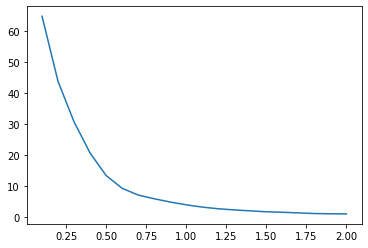

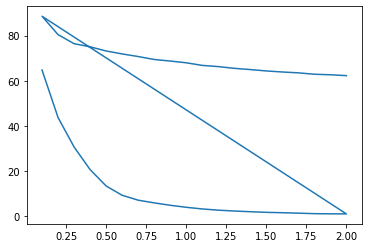

In [4]:
# plt.hist(merged,bins=100)
dwells_w = np.array(merged_w)
dwells_s = np.array(merged_s)
print(dwells_w.mean(),dwells_s.mean())
x=[]
y=[]
def plot_dwell(dwells):
    for i in np.arange(100,2010,step=100):
        i=i/1000
        print(i,':  ',len(dwells[dwells>i]),len(dwells[dwells>i])/len(dwells)*100,'%')
        x.append(i)
        y.append(len(dwells[dwells>i])/len(dwells)*100)
    plt.plot(x,y)
    plt.show()
plot_dwell(dwells_w)

print('-'*20)
plot_dwell(dwells_s)